<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd, seaborn as sb, numpy as np, matplotlib.pyplot as plt

names = [
         "CO_UF",
         "CO_MUNICIPIO",
         "IN_CAPITAL",
         "CO_CURSO", 
         "IN_AJUDA_DEFICIENTE", 
         "IN_MATERIAL_DIGITAL", 
         "IN_MATERIAL_AMPLIADO",
         "IN_MATERIAL_TATIL", 
         "IN_MATERIAL_IMPRESSO", 
         "IN_MATERIAL_AUDIO",
         "IN_MATERIAL_BRAILLE",
         "IN_MATERIAL_LIBRAS",
         "IN_DISCIPLINA_LIBRAS",
         "IN_TRADUTOR_LIBRAS",
         "IN_GUIA_INTERPRETE",
         "IN_RECURSOS_COMUNICACAO",
         "IN_RECURSOS_INFORMATICA"
         ]

         
dataset = pd.read_csv("teste_ies.csv", names=names, sep='|', encoding='latin-1')

#Substitui NaN por 0
dataset.fillna(0, inplace=True)

Processa células não padronizadas (células vazias)

In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in dataset.columns:
  if dataset[i].dtype == object:
    dataset[i] = le.fit_transform(dataset[i])
  else:
    pass

Normaliza os dados usando StandardScaler e treina o modelo

In [70]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 4].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Faz a predição

[[3 0 0]
 [0 8 0]
 [0 0 4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Text(0, 0.5, 'Mean Error')

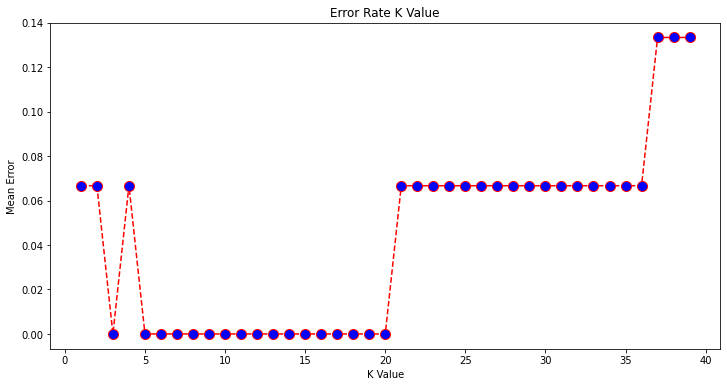

In [71]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')